## Upscaler using ISR (Image Super Resolution)

> The current notebook is part of [AI Image Editing and Manipulation](https://github.com/afondiel/computer-vision-challenge/blob/main/L2_06_AI_Assisted_Image_Editing_and_Manipulation/) pipeline from [**Computer Vision Challenge**](https://github.com/afondiel/computer-vision-challenge).

<img width="400" height="400" src="https://github.com/afondiel/computer-vision-challenge/blob/main/L2_06_AI_Assisted_Image_Editing_and_Manipulation/docs/pipeline-last.png?raw=true">


|--|Notebook|Demo (Gradio)|
|--|--|--|
||[![Open notebook in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/afondiel/computer-vision-challenge/blob/main/L2_06_AI_Assisted_Image_Editing_and_Manipulation/notebooks/Upscaler_ISR.ipynb)|[HF Space (Ongoing)](https://huggingface.co/spaces)|

### Install Dependencies

In [1]:
# Installs the necessary dependencies for image super-resolution and enhancement.

!pip install ISR --no-deps
!pip install torch torchvision torchaudio fastai timm -U
!pip install transformers datasets
!pip install gradio gradio_imageslider

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.5/234.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 47.8 MB/s eta 0:00:00
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.16
    Uninstalling fastai-2.7.16:
      Successfully uninstalled fastai-2.7.16
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not cur

### Import Libraries

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from ISR.models import RDN  # Import the ISR model
import gradio as gr
from gradio_imageslider import ImageSlider

### Preprocessing & Transformation

In [3]:
# Function to load dataset from Hugging Face
def load_dataset_from_hf(dataset_name="afondiel/dummy_images"):
    """
    Loads a dataset from Hugging Face.

    Args:
        dataset_name (str): The name of the dataset to load.

    Returns:
        DatasetDict: A dictionary containing the loaded dataset.
    """
    from datasets import load_dataset
    return load_dataset(dataset_name)

# Function to preprocess images
def preprocess_images(dataset):
    """
    Extracts and preprocesses images from the dataset.

    Args:
        dataset (DatasetDict): The dataset containing images.

    Returns:
        list: A list of preprocessed PIL images.
    """
    image_list = []

    for example in dataset['test']:
        im = example['image']

        if isinstance(im, str):
            img = Image.open(im)
        elif isinstance(im, dict):
            img = Image.open(BytesIO(requests.get(im['path']).content))
        elif isinstance(im, Image.Image):
            img = im
        else:
            raise ValueError("Invalid image format")

        image_list.append(img)

    return image_list

# Function to convert image to numpy array and handle grayscale images
def convert_image_to_numpy(image):
    """
    Converts a PIL image to a numpy array and handles grayscale images.

    Args:
        image (PIL.Image.Image): The image to convert.

    Returns:
        np.array: The converted numpy array.
    """
    input_img = np.array(image)

    if len(input_img.shape) == 2:  # Grayscale image
        input_img = cv2.cvtColor(input_img, cv2.COLOR_GRAY2RGB)
    elif len(input_img.shape) == 3 and input_img.shape[2] == 3:  # Color image
        input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)

    return input_img


# Function to display images
def display_images(input_img, sr_img):
    """
    Displays the original and super-resolved images side by side.

    Args:
        input_img (np.array): The original input image.
        sr_img (np.array): The super-resolved image.
    """
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(input_img)
    plt.subplot(1, 2, 2)
    plt.title('Super-Resolution Image')
    plt.imshow(sr_img)
    plt.show()

### Upscaler using ISR (Image Super Resolution)

> **The `RDN` model summary**

| Weights | Model Size | Training Objective | Scaling Factor |Resolution|
|---|---|---|---|---|
| `psnr-small` | Smaller | PSNR | 2x | 2k |
| `psnr-large` | Larger | PSNR | 4x | 4k |
| `gans` | Varies | GAN | 2x or 4x | 2k or 4k |

In [4]:
def super_resolution(input_img, weights='psnr-small'):
    """
    Performs super-resolution on an image using the ISR model.

    Args:
        input_img (np.array): The input image in numpy array format.
        weights (str): The type of weights to use for the ISR model.

    Returns:
        np.array: The super-resolved image.
    """
    rdn = RDN(weights=weights)
    sr_img = rdn.predict(input_img)
    return sr_img


Selected weight: S, type:<class 'str'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


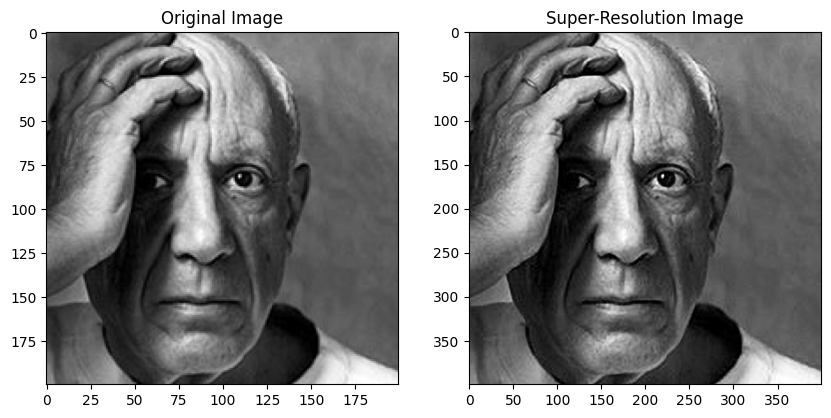

In [9]:
# ---------------------------------------
# Main: running the app
# ---------------------------------------

# Run the main function
if __name__ == "__main__":
  """
  Super-resolution process pipeline with ISR
  """
  weight_types = {
      "S": "psnr-small",
      "L": "psnr-large",
      "G": "gans",
  }

  selected_weight =  "S" #@param ["S", "L", "G"] {type:"raw"}
  selected_weight = str(selected_weight)
  print(f"Selected weight: {selected_weight}, type:{type(selected_weight)}")

  # Load the dataset
  dataset = load_dataset_from_hf("afondiel/dummy_images")

  # Preprocess images
  images = preprocess_images(dataset)
  input_img = convert_image_to_numpy(images[1])

  # Perform super-resolution based on the selected weights
  if selected_weight == "S":
    sr_img = super_resolution(input_img=input_img, weights=weight_types[selected_weight])
  elif selected_weight == "L":
    sr_img = super_resolution(input_img=input_img, weights=weight_types[selected_weight])
  elif selected_weight == "G":
    sr_img = super_resolution(input_img=input_img, weights=weight_types[selected_weight])
  else:
    print("Invalid weight selected")

  # Display the images
  display_images(input_img, sr_img)


### App Demo with Gradio

> **WARNING:**
- ISR is a resource-efficient deeplearning model that handles quite well upscaling task for **low-resolution** images. Therefore, upscaling **large images** can be very painful leading to `out of memory` errors. Here are some solutions:

- Switch to a larger weight: S, L, ...
- Use a more powerful machine with more memory and GPUs.
- Try switching to a high-RAM runtime
- Downscale the image before upscaling
- Explore different library : [HF Diffusion Upscaler](https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/upscale)

In [12]:
# Nested demo inside to be export into another modules
def launch_gradio_demo():
    """
    Launches a Gradio demo for upscaling images.
    """
    def upscale_with_gradio(image, selected_weight):
        # Convert the image to numpy format
        input_img = convert_image_to_numpy(image)

        # Perform super-resolution
        # sr_img = super_resolution(input_img)
        if selected_weight == "S":
          sr_img = super_resolution(input_img=input_img, weights="psnr-small")
        elif selected_weight == "L":
          sr_img = super_resolution(input_img=input_img, weights="psnr-large")
        elif selected_weight == "G":
          sr_img = super_resolution(input_img=input_img, weights="gans")
        else:
          print("Invalid weight selected")
        # Convert back to PIL for displaying in Gradio
        sr_img_pil = Image.fromarray(sr_img)

        return [image, sr_img_pil]

    demo = gr.Interface(
        fn=upscale_with_gradio,
        # inputs=[gr.Image(type="pil"), gr.Radio(["2k", "4k", "R"], label="Select Model Weight", value="S")],
        inputs=[gr.Image(type="pil"), gr.Radio(["S", "L", "G"], label="Select Model Weight", value="S")],
        outputs=ImageSlider(),
        title="Image Upscaler - ISR",
        description="Upload an image to see the upscaled result side-by-side.",
        examples=[[images[1]]]
        # allow_flagging="never",
    )

    demo.launch()

In [13]:
# launch demo
launch_gradio_demo()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://08848045b3c50c9042.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## References

**Docs:**

- [AI Image Restoration](https://en.wikipedia.org/wiki/Image_restoration_by_artificial_intelligence)
- HF Documentation: https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/upscale

**Datasets:**

- [Awesome Datasets for Super-Resolution: Introduction and Pre-processing - 2023](https://openmmlab.medium.com/awesome-datasets-for-super-resolution-introduction-and-pre-processing-55f8501f8b18)

ISR:
- DIV2K
- DF2K
- EDSR - paper:
  - [Enhanced Deep Residual Networks for Single Image Super-Resolution - paper](https://arxiv.org/pdf/1707.02921)

Real-ESRGAN:
- DF2K_OST

face super resolution:
- [FFHQ](https://paperswithcode.com/dataset/ffhq) and [CelebA-HQ](https://)

**Models:**

ISR Resources:
- [Image Super Resolution (ISR) github project with tf](https://github.com/idealo/image-super-resolution)
- [Paper with Code:](https://paperswithcode.com/paper/residual-dense-network-for-image-super)
  - paper: [Residual Dense Network for Image Super-Resolution CVPR 2018](https://openaccess.thecvf.com/content_cvpr_2018/papers/Zhang_Residual_Dense_Network_CVPR_2018_paper.pdf)

  - code: [RDN - @yulunzhang](https://github.com/yulunzhang/RDN)

Real-ESRGAN:
- Paper: [Real-ESRGAN: Training Real-World Blind Super-Resolution with Pure Synthetic Data](https://arxiv.org/pdf/2107.10833)
- [HF Space](https://huggingface.co/spaces/akhaliq/Real-ESRGAN)

ESRGAN:

[Enhanced Super-Resolution Generative Adversarial Networks - paper 2018](https://arxiv.org/pdf/1809.00219)

**Diffusions:**
- stable-diffusion-x4-upscaler - stabilityai: https://huggingface.co/stabilityai/stable-diffusion-x4-upscaler
